In [1]:
# my dataset
!pip install kaggle
!kaggle datasets download -d safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb
!unzip german-traffic-sign-detection-benchmark-gtsdb.zip -d /content/dataset

# yolo5 model
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


Dataset URL: https://www.kaggle.com/datasets/safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb
License(s): unknown
 99% 1.60G/1.61G [00:15<00:00, 259MB/s]
100% 1.61G/1.61G [00:15<00:00, 111MB/s]
Archive:  german-traffic-sign-detection-benchmark-gtsdb.zip
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00000.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00001.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00002.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00003.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00004.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00005.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00006.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00007.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00008.ppm  
  inflating: /content/dataset/Tes

In [ ]:
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import shutil

#  Paths
dataset_path = "/content/dataset/TrainIJCNN2013/TrainIJCNN2013"
output_path = "/content/yolov5_data"
os.makedirs(f"{output_path}/train/images", exist_ok=True)
os.makedirs(f"{output_path}/train/labels", exist_ok=True)
os.makedirs(f"{output_path}/val/images", exist_ok=True)
os.makedirs(f"{output_path}/val/labels", exist_ok=True)

# Read annotations
annotations = {}
with open(os.path.join(dataset_path, "gt.txt"), "r") as file:
    for line in file.readlines():
        parts = line.strip().split(";")
        image_name, x_min, y_min, x_max, y_max, label = parts
        bbox = [int(x_min), int(y_min), int(x_max), int(y_max), int(label)]
        annotations.setdefault(image_name, []).append(bbox)

# Train-validation split
image_files = list(annotations.keys())
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Convert Bounding Box to YOLO Format
def convert_to_yolo(bbox, img_w, img_h):
    x_min, y_min, x_max, y_max, label = bbox
    x_center = ((x_min + x_max) / 2) / img_w
    y_center = ((y_min + y_max) / 2) / img_h
    width = (x_max - x_min) / img_w
    height = (y_max - y_min) / img_h
    return f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

# Process dataset
def process_split(image_list, split_name):
    for img_name in image_list:
        img_path = os.path.join(dataset_path, img_name)
        img = Image.open(img_path)
        img_w, img_h = img.size
        img.save(f"{output_path}/{split_name}/images/{img_name.replace('.ppm', '.jpg')}")

        with open(f"{output_path}/{split_name}/labels/{img_name.replace('.ppm', '.txt')}", "w") as label_file:
            for bbox in annotations[img_name]:
                yolo_bbox = convert_to_yolo(bbox, img_w, img_h)
                label_file.write(f"{yolo_bbox}\n")

process_split(train_files, "train")
process_split(val_files, "val")


In [5]:
# Step 1: Defining the configuration file (gtsdb.yaml)

with open("data/gtsdb.yaml", "w") as f:
    f.write("""
# GTSDB Dataset Configuration
# Define paths and class names for YOLOv5 training

# Base dataset path
path: /content/yolov5_data  # Update this path if using a different directory

# Paths to the training and validation image folders
train: train/images
val: val/images

# Number of classes (traffic sign classes in GTSDB)
nc: 43

# Class names
names: [
    'Speed limit 20', 'Speed limit 30', 'Speed limit 50', 'Speed limit 60',
    'Speed limit 70', 'Speed limit 80', 'End of speed limit 80', 'Speed limit 100',
    'Speed limit 120', 'No overtaking', 'No overtaking (trucks)', 'Priority at next intersection',
    'Priority road', 'Give way', 'Stop', 'No traffic both ways',
    'No trucks', 'No entry', 'Danger', 'Bend left',
    'Bend right', 'Bend', 'Uneven road', 'Slippery road',
    'Road narrows', 'Construction', 'Traffic signal', 'Pedestrian crossing',
    'Children crossing', 'Bicycles crossing', 'Snow', 'Animals crossing',
    'Restrictions end', 'Go right', 'Go left', 'Go straight',
    'Go right or straight', 'Go left or straight', 'Keep right', 'Keep left',
    'Roundabout', 'End of no overtaking', 'End no passing veh > 3.5 tons'
]
""")

# Step 2: Train the model
!python train.py --img 640 --batch 16 --epochs 30 --data data/gtsdb.yaml --weights yolov5s.pt --project GTSDB --name yolov5_gtsdb_finetune


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-17 13:27:18.014570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 13:27:18.034162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 13:27:18.040016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

val: data=data/gtsdb.yaml, weights=['GTSDB/yolov5_gtsdb_finetune/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7126096 parameters, 0 gradients, 16.1 GFLOPs
val: Scanning /content/yolov5_data/val/labels.cache... 102 images, 0 backgrounds, 0 corrupt: 100% 102/102 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/yolov5_data/val/images/00340.jpg: 1 duplicate labels removed
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:06<00:00,  1.64s/it]
                   all        102        159      0.638      0.231      0.127     0.0962
        Speed limit 20       

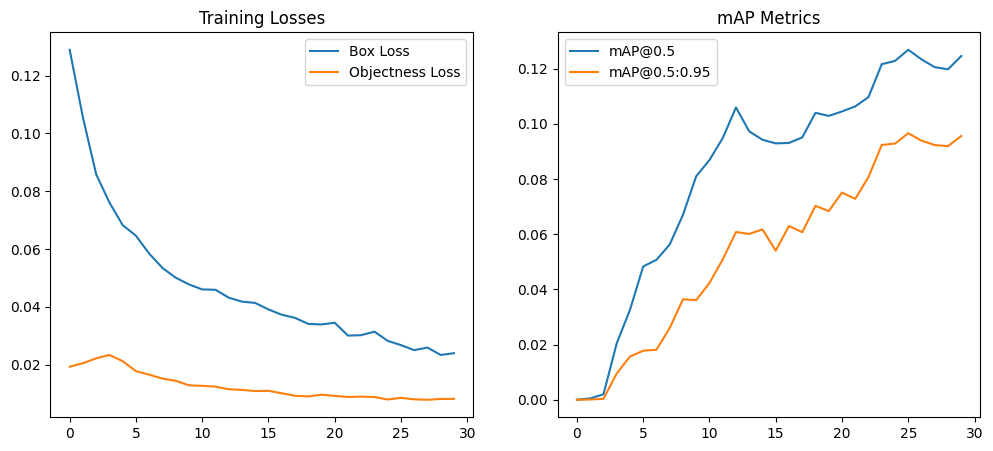

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from yolov5.utils.metrics import fitness

# Step 1: Evaluate the model
#Validation: how well the model performs on a validation dataset
!python val.py --data data/gtsdb.yaml --weights GTSDB/yolov5_gtsdb_finetune/weights/best.pt --img 640

# Step 2: Calculate IoU for each class from the results of the evaluation


metrics_path = "/content/yolov5/GTSDB/yolov5_gtsdb_finetune/results.csv"  
df = pd.read_csv(metrics_path)


print(df.columns)

#IoU scores - metrics/precision
iou_scores = df['   metrics/precision'].values


print(f"Mean IoU per class: {iou_scores.mean():.4f}")


# Step 3: Plot Loss and mAP metrics
results_path = "/content/yolov5/GTSDB/yolov5_gtsdb_finetune/results.csv"
df = pd.read_csv(results_path)

# Training Losses
plt.figure(figsize=(12, 5))

plt.subplot(2, 3, 2)
plt.plot(df['      train/box_loss'], label='Box Loss')
plt.plot(df['      train/obj_loss'], label='Objectness Loss')
plt.legend()
plt.title('Training Losses')

# mAP Metrics
plt.subplot(2, 3, 3)
plt.plot(df['     metrics/mAP_0.5'], label='mAP@0.5')
plt.plot(df['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
plt.legend()
plt.title('mAP Metrics')

plt.show()


detect: weights=['GTSDB/yolov5_gtsdb_finetune/weights/best.pt'], source=/content/yolov5_data/val/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7126096 parameters, 0 gradients, 16.1 GFLOPs
image 1/102 /content/yolov5_data/val/images/00000.jpg: 384x640 (no detections), 27.7ms
image 2/102 /content/yolov5_data/val/images/00002.jpg: 384x640 (no detections), 7.8ms
image 3/102 /content/yolov5_data/val/images/00009.jpg: 384x640 (no detections), 7.7ms
image 4/102 /content/yolov5_data

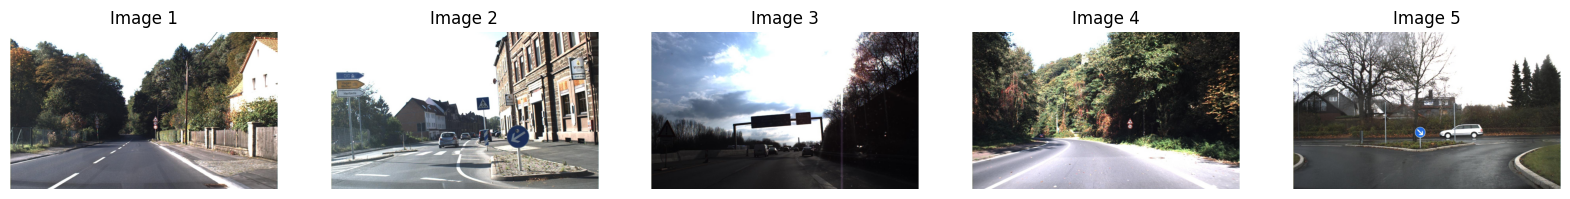

In [ ]:
#Object Detection on dataset using best weights
!python detect.py --weights GTSDB/yolov5_gtsdb_finetune/weights/best.pt --source /content/yolov5_data/val/images --conf 0.25 --save-txt --save-conf

import cv2
import matplotlib.pyplot as plt
from glob import glob

#  some results
result_images = glob('/content/yolov5/runs/detect/exp/*.jpg')
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for i, img_path in enumerate(result_images[:5]):
    img = cv2.imread(img_path)
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")
plt.show()

#image 90, 132, 206


In [8]:
import pandas as pd

# to check file names
metrics_path = "/content/yolov5/GTSDB/yolov5_gtsdb_finetune/results.csv"
df = pd.read_csv(metrics_path)

print("Available columns in the CSV file:")
print(df.columns)


Available columns in the CSV file:
Index(['               epoch', '      train/box_loss', '      train/obj_loss',
       '      train/cls_loss', '   metrics/precision', '      metrics/recall',
       '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss',
       '        val/obj_loss', '        val/cls_loss', '               x/lr0',
       '               x/lr1', '               x/lr2'],
      dtype='object')


In [11]:
!ls -R /content/yolov5

/content/yolov5:
benchmarks.py	 data	    hubconf.py	 pyproject.toml    runs		   utils
CITATION.cff	 detect.py  LICENSE	 README.md	   segment	   val.py
classify	 export.py  models	 README.zh-CN.md   train.py	   yolov5s.pt
CONTRIBUTING.md  GTSDB	    __pycache__  requirements.txt  tutorial.ipynb

/content/yolov5/classify:
predict.py  train.py  tutorial.ipynb  val.py

/content/yolov5/data:
Argoverse.yaml	  GlobalWheat2020.yaml	ImageNet100.yaml  Objects365.yaml  VOC.yaml
coco128-seg.yaml  gtsdb.yaml		ImageNet10.yaml   scripts	   xView.yaml
coco128.yaml	  hyps			ImageNet.yaml	  SKU-110K.yaml
coco.yaml	  ImageNet1000.yaml	images		  VisDrone.yaml

/content/yolov5/data/hyps:
hyp.no-augmentation.yaml  hyp.scratch-high.yaml  hyp.scratch-med.yaml
hyp.Objects365.yaml	  hyp.scratch-low.yaml	 hyp.VOC.yaml

/content/yolov5/data/images:
bus.jpg  zidane.jpg

/content/yolov5/data/scripts:
download_weights.sh  get_coco.sh	  get_imagenet100.sh  get_imagenet.sh
get_coco128.sh	     get_imagenet1000.sh  get_i

In [21]:
import shutil
from google.colab import files

folder_path = '/content/yolov5/runs/detect/exp'
zip_file_path = '/content/exp.zip'

shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

files.download(zip_file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
from google.colab import files

file_path = '/content/yolov5/GTSDB/yolov5_gtsdb_finetune/weights/best.pt'

files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>